In [16]:
import math
from random import shuffle
from copy import deepcopy
import torch
import torch.nn.functional as tfunc
import matplotlib.pyplot as plt


torch.set_default_device("cuda")

# Building Dataset

In [17]:
words = open("../names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
char_to_indx = {char: indx+1 for indx, char in enumerate(chars)}
char_to_indx["."] = 0
indx_to_char = {indx: char for char, indx in char_to_indx.items()}

def train_dev_test_split(words, train_percentage, dev_percentage):
    shuffled_words = deepcopy(words)
    shuffle(shuffled_words)
    train_dev_split_point = math.ceil(len(words) * train_percentage)
    dev_val_split_point = math.floor(
        train_dev_split_point + (len(words) * dev_percentage)
    )
    return (
        shuffled_words[:train_dev_split_point],
        shuffled_words[train_dev_split_point:dev_val_split_point],
        shuffled_words[dev_val_split_point:],
    )

def create_dataset(words, char_to_indx, block_size = 3):
    inputs, labels = [], []
    for word in words:
        # print(word)
        context = [0] * block_size
        for label in word + ".":
            label_indx = char_to_indx[label]
            inputs.append(context)
            labels.append(label_indx)
            # print("".join(indx_to_char[indx] for indx in context), "------>", label)
            context = context[1:] + [label_indx]
        # print()

    return torch.tensor(inputs), torch.tensor(labels)

BLOCK_SIZE = 5
train_words, dev_words, test_words = train_dev_test_split(words, 0.8, 0.1)
train_inputs, train_labels = create_dataset(train_words, char_to_indx, block_size=BLOCK_SIZE)
dev_inputs, dev_labels = create_dataset(dev_words, char_to_indx, block_size=BLOCK_SIZE)
test_inputs, test_labels = create_dataset(test_words, char_to_indx, block_size=BLOCK_SIZE)

# Initializing Model Params

In [82]:
# Params
gen = torch.Generator(device="cuda").manual_seed(2147483647)
EMBED_NUM = 30
HIDDEN_NUM = 300
DOWN_SCALE_PARAMS = (0.07, 0.01, 0.01, 0)

# Uniform configurable params
C = torch.randn((27, EMBED_NUM), requires_grad=True) # Lookup table
weights1 = (torch.randn((BLOCK_SIZE * EMBED_NUM, HIDDEN_NUM), requires_grad=True) * DOWN_SCALE_PARAMS[0]).detach().requires_grad_()
bias1 = (torch.randn(HIDDEN_NUM, requires_grad=True) * DOWN_SCALE_PARAMS[1]).detach().requires_grad_()
weights2 = (torch.randn((HIDDEN_NUM, 27), requires_grad=True) * DOWN_SCALE_PARAMS[2]).detach().requires_grad_()
bias2 = (torch.randn(27, requires_grad=True) * DOWN_SCALE_PARAMS[3]).detach().requires_grad_()

parameters = [C, weights1, bias1, weights2, bias2]
print(f"TOTAL PARAMS: {sum([param.nelement() for param in parameters])}")

TOTAL PARAMS: 54237


# Training Model

In [83]:
EPOCHS = 200000
MINI_BATCH_SIZE = 100
LOG_EVERY = 10000

losses = []
learning_rate = 0.1
for indx in range(0, EPOCHS):
    mini_batch_indxs = torch.randint(0, train_inputs.shape[0], (MINI_BATCH_SIZE,))
    mini_batch_inputs = train_inputs[mini_batch_indxs]
    mini_batch_labels = train_labels[mini_batch_indxs]

    embed = C[mini_batch_inputs]
    joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
    layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
    logits = layer1_out @ weights2 + bias2
    loss = tfunc.cross_entropy(logits, mini_batch_labels)

    for param in parameters:
        param.grad = None

    if indx < 2 * EPOCHS // 3: learning_rate = 0.01 
    loss.backward(retain_graph=True)
    for param in parameters:
        param.data += -learning_rate * param.grad
    
    if indx % LOG_EVERY == 0: print(f"{indx}/{EPOCHS} : {loss.item()}")
    losses.append(loss.log10().item()
)

0/200000 : 3.2907729148864746
10000/200000 : 2.20538330078125
20000/200000 : 2.0807549953460693
30000/200000 : 2.1469502449035645
40000/200000 : 1.9868004322052002
50000/200000 : 1.9507622718811035
60000/200000 : 2.0602102279663086
70000/200000 : 1.7942310571670532
80000/200000 : 2.1727030277252197
90000/200000 : 1.8484928607940674
100000/200000 : 2.107382297515869
110000/200000 : 2.2769479751586914
120000/200000 : 1.747376561164856
130000/200000 : 1.7926944494247437
140000/200000 : 1.8795148134231567
150000/200000 : 1.8930063247680664
160000/200000 : 1.6277934312820435
170000/200000 : 1.8957114219665527
180000/200000 : 2.0033257007598877
190000/200000 : 1.9693329334259033


# Training loss curve plot

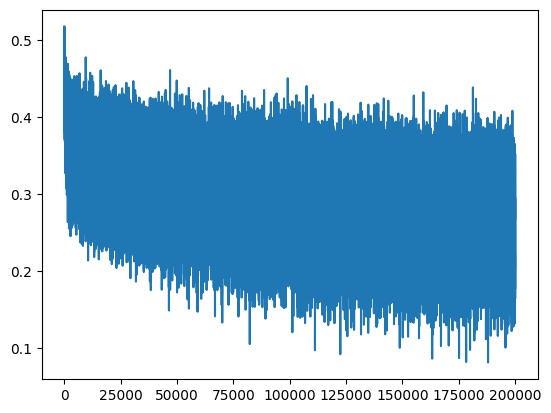

In [84]:
plt.plot(list(range(EPOCHS)), losses)

# Eval Model with Dev Data

In [85]:
@torch.no_grad()
def calc_loss(inputs, labels):
    embed = C[inputs]
    joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
    layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
    logits = layer1_out @ weights2 + bias2
    loss = tfunc.cross_entropy(logits, labels)
    return loss

print(f"Train loss: {calc_loss(train_inputs, train_labels).item()}")
print(f"Dev loss: {calc_loss(dev_inputs, dev_labels).item()}")

Train loss: 1.877923607826233
Dev loss: 2.025822877883911


In [ ]:
# Best train loss: 1.877923607826233
# Best dev loss: 2.025822877883911

# Sample from the model

In [10]:
NUM_SAMPLES = 20
g = torch.Generator(device="cuda").manual_seed(2147483647 + 10)
for _ in range(NUM_SAMPLES): 
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        embed = C[torch.tensor([context])]
        joined_embed = embed.view(embed.shape[0], embed.shape[1] * embed.shape[2])
        layer1_out = torch.tanh(joined_embed @ weights1 + bias1)
        logits = layer1_out @ weights2 + bias2
        probs = tfunc.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
  
    print(''.join(indx_to_char[i] for i in out)) # decode and print the generated word

brentse.
ezrieh.
francar.
harsrahlee.
lidzyon.
rahhend.
chrac.
adoni.
jensin.
melo.
arellonk.
alstende.
tengzond.
kaylah.
aannj.
ruany.
doria.
aviri.
thiyen.
moraya.
